## Harris Corner Detection

### Step 0: Load Image

C:\Users\c\AppData\Local\Temp\ipykernel_25704\1875231321.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Chessboard_calibration_setup.png/576px-Chessboard_calibration_setup.png")[..., 0:1]


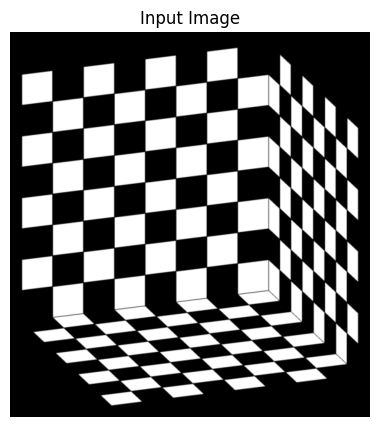

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from scipy import ndimage

image = imread("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Chessboard_calibration_setup.png/576px-Chessboard_calibration_setup.png")[..., 0:1]
image = image.astype(np.float32)

plt.figure(figsize=(5, 5))
if image.shape[-1] == 1:
    plt.imshow(image.astype(np.uint8), cmap='gray')
else:
    plt.imshow(image.astype(np.uint8))
plt.title('Input Image')
plt.axis('off')
plt.show()

### Step 1: Compute Image Gradients

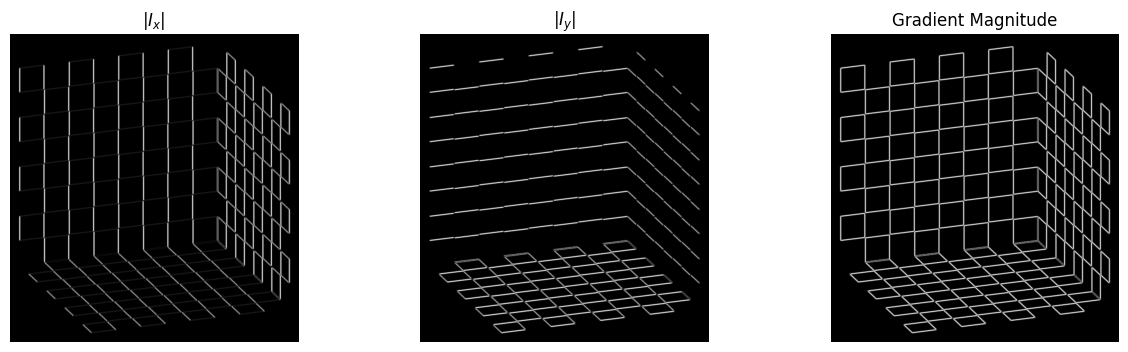

In [3]:
def compute_gradients(image):
    # Compute gradients using Sobel filters
    Ix = ndimage.sobel(image, axis=1)
    Iy = ndimage.sobel(image, axis=0)
    return Ix, Iy

def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

Ix, Iy = compute_gradients(image / 255)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(normalize(np.abs(Ix)), cmap='gray')
plt.title('$|I_x|$')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(normalize(np.abs(Iy)), cmap='gray')
plt.title('$|I_y|$')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(normalize(np.hypot(Ix, Iy)), cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.show()


### Step 2: Eigenvalue Intuition

In [4]:
def local_harris_matrix(Ix, Iy, x, y, window_size=5):
    w = window_size // 2
    Ix_window = Ix[y-w:y+w+1, x-w:x+w+1]
    Iy_window = Iy[y-w:y+w+1, x-w:x+w+1]

    Ixx = np.sum(Ix_window**2)
    Iyy = np.sum(Iy_window**2)
    Ixy = np.sum(Ix_window * Iy_window)
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
    return M

def plot_harris_eigenvalues(Ix, Iy, x, y, window_size=5):
    M = local_harris_matrix(Ix, Iy, x, y, window_size)
    eigvals, eigvecs = np.linalg.eig(M)

    print(f"Location: (x={x}, y={y})")
    print("Harris matrix:")
    print(M)
    print("Eigenvalues:", eigvals)

    fig, ax = plt.subplots()
    ax.set_title("Eigenvalue Ellipse Visualization")
    ax.set_aspect('equal')
    ax.grid(True)

    ellipse = plt.Circle((0, 0), 1, color='lightgray', fill=False)
    ax.add_patch(ellipse)

    for i in range(2):
        vec = eigvecs[:, i]
        length = np.sqrt(eigvals[i])
        ax.arrow(0, 0, vec[0]*length, vec[1]*length, head_width=1, color='r')

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.xlabel('dx')
    plt.ylabel('dy')
    plt.show()

def interpret_eigenvalues(e1, e2, threshold=200):
    if e1 < threshold and e2 < threshold:
        return "Flat region"
    elif min(e1, e2) < threshold:
        return "Edge-like region"
    else:
        return "Corner region"


#### Interactive Visualization

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.patches import Ellipse

def interactive_harris_click(image, Ix, Iy):
    h, w = image.shape[:2]

    x_slider = widgets.IntSlider(min=0, max=w-1, value=w//2, description='x')
    y_slider = widgets.IntSlider(min=0, max=h-1, value=h//2, description='y')

    img_box = widgets.Output()
    eig_box = widgets.Output()
    log_box = widgets.Output()

    def update(x, y):
        M = local_harris_matrix(Ix, Iy, x, y)
        eigvals, eigvecs = np.linalg.eig(M)
        interpretation = interpret_eigenvalues(*eigvals)

        # --- Plot: Image view ---
        fig1, ax1 = plt.subplots(figsize=(5, 5))
        ax1.imshow(image.astype(np.uint8), cmap='gray')
        ax1.plot(x, y, 'ro', markersize=8)
        ax1.set_title(f"Image (x={x}, y={y})")
        ax1.axis('off')

        # --- Plot: True Ellipse view ---
        fig2, ax2 = plt.subplots(figsize=(5, 5))
        ax2.set_title(f"Eigenvalue Ellipse\n{interpretation}")
        ax2.set_aspect('equal')
        ax2.grid(True)

        # Calculate ellipse parameters
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width = 2 * np.sqrt(eigvals[0])
        height = 2 * np.sqrt(eigvals[1])

        ellipse = Ellipse((0, 0), width=width, height=height, angle=angle,
                          edgecolor='red', facecolor='none', lw=2)
        ax2.add_patch(ellipse)

        # Optional: draw eigenvectors as arrows
        for i in range(2):
            vec = eigvecs[:, i]
            length = np.sqrt(eigvals[i])
            ax2.arrow(0, 0, vec[0]*length, vec[1]*length, head_width=0.5, color='blue')

        ax2.set_xlim(-50, 50)
        ax2.set_ylim(-50, 50)
        ax2.set_xlabel("dx")
        ax2.set_ylabel("dy")

        # --- Display ---
        with img_box:
            clear_output(wait=True)
            display(fig1)
            plt.close(fig1)

        with eig_box:
            clear_output(wait=True)
            display(fig2)
            plt.close(fig2)

        with log_box:
            clear_output(wait=True)
            print("Harris matrix:\n", M)
            print("Eigenvalues:", eigvals)
            print("Interpretation:", interpretation)

    ui = widgets.VBox([x_slider, y_slider])
    out = widgets.interactive_output(update, {'x': x_slider, 'y': y_slider})

    display(ui)
    display(widgets.HBox([img_box, eig_box]))
    display(log_box)



interactive_harris_click(image, Ix, Iy)

Output()

### Step 3: Implement Harris Detector

In [57]:
def compute_harris_response(Ix, Iy, sigma=1, k=0.05):
    Ixx = ndimage.gaussian_filter(Ix**2, sigma)
    Iyy = ndimage.gaussian_filter(Iy**2, sigma)
    Ixy = ndimage.gaussian_filter(Ix*Iy, sigma)

    detM = Ixx * Iyy - Ixy**2
    traceM = Ixx + Iyy
    R = detM - k * traceM**2
    return R

### Step 4: Thresholding and NMS

In [58]:
def detect_corners(R, threshold_ratio=0.01, window_size=3):
    # If RGB response, average across channels
    if R.ndim == 3:
        R = np.mean(R, axis=2)

    threshold = threshold_ratio * R.max()
    corners = (R > threshold)
    size = window_size // 2
    coordinates = []
    for y in range(size, R.shape[0] - size):
        for x in range(size, R.shape[1] - size):
            window = R[y-size:y+size+1, x-size:x+size+1]
            if R[y, x] == np.max(window) and corners[y, x]:
                coordinates.append((y, x))
    return coordinates


### Step 5: Run Pipeline and Visualize

C:\Users\c\AppData\Local\Temp\ipykernel_25704\3173377589.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Sagrada_familia_construction_differences.jpg/500px-Sagrada_familia_construction_differences.jpg")


Total number of detected corners: 2023


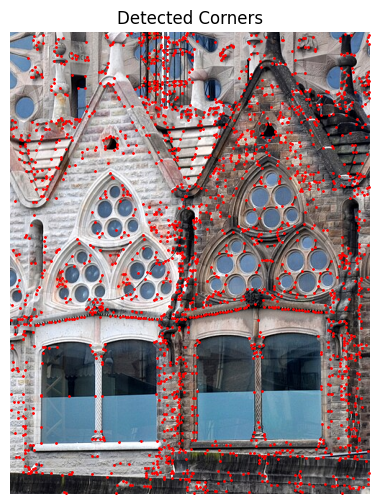

In [59]:
def plot_corners(image, corners):
    plt.figure(figsize=(6, 6))
    if image.shape[-1] == 1:
        plt.imshow(image.astype(np.uint8), cmap='gray')
    else:
        plt.imshow(image.astype(np.uint8))
    for y, x in corners:
        plt.plot(x, y, 'ro', markersize=1)
    plt.title('Detected Corners')
    plt.axis('off')
    plt.show()

def harris_pipeline(image):
    Ix, Iy = compute_gradients(image)
    R = compute_harris_response(Ix, Iy, k=0.05)
    corners = detect_corners(R)

    return corners

# Run the pipeline
image = imread("https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Sagrada_familia_construction_differences.jpg/500px-Sagrada_familia_construction_differences.jpg")
image = image.astype(np.float32)
corners = harris_pipeline(image)

# Code added to report the total number of detected corners
print(f"Total number of detected corners: {len(corners)}")

plot_corners(image, corners)

### Feel free to add cells to visualize the results for solving the problem.